In [1]:
import numpy as np
import os
import math
from pathlib import Path
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.applications import ResNet50

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import json

## Data reading & visizalition 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
train_dir= Path('/content/gdrive/My Drive/Colab Notebooks/big_data_final/chest_xray/train')
test_dir = Path('/content/gdrive/My Drive/Colab Notebooks/big_data_final/chest_xray/test')
val_dir  = Path('/content/gdrive/My Drive/Colab Notebooks/big_data_final/chest_xray/val')

files_path_train= list(train_dir.glob(r'*/*.jpeg'))
files_path_test= list(test_dir.glob(r'*/*.jpeg'))
files_path_val = list(val_dir.glob(r'*/*.jpeg'))

labels_train= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_train)) 
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_test))
labels_val= list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files_path_val))

In [4]:
#create the columns for the dataframes
labels_train= pd.Series(labels_train, name= 'Label')
labels_test= pd.Series(labels_test, name= 'Label')
labels_val = pd.Series(labels_val, name= 'Label')

images_train= pd.Series(files_path_train, name= 'Filepath').astype(str)
images_test = pd.Series(files_path_test, name= 'Filepath').astype(str)
images_val = pd.Series(files_path_val, name= 'Filepath').astype(str)

#create the dataframes
train_df= pd.concat([images_train, labels_train], axis=1)
test_df = pd.concat([images_test, labels_test], axis=1)
val_df= pd.concat([images_val, labels_val], axis=1)

train_df.head()

,Filepath,Label
0,/content/gdrive/My Drive/Colab Notebooks/big_d...,PNEUMONIA
1,/content/gdrive/My Drive/Colab Notebooks/big_d...,PNEUMONIA
2,/content/gdrive/My Drive/Colab Notebooks/big_d...,PNEUMONIA
3,/content/gdrive/My Drive/Colab Notebooks/big_d...,PNEUMONIA
4,/content/gdrive/My Drive/Colab Notebooks/big_d...,PNEUMONIA


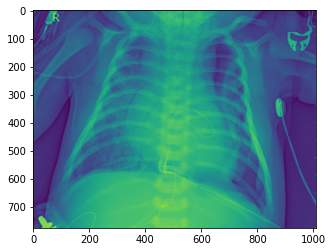

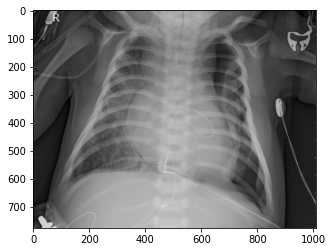

In [5]:
img = imread(train_df['Filepath'][0])
plt.imshow(img)
plt.show()
plt.imshow(img, cmap = 'gray')
plt.show()

In [6]:
def images_formate(df,x_col,label_col,b_size = 32, w= 50,h= 50):
    im_gen = ImageDataGenerator(samplewise_center= True,
                                       samplewise_std_normalization= True)
    
    images = im_gen.flow_from_dataframe(dataframe = df, x_col = x_col,
                                        y_col = label_col,class_mode = 'binary', 
                                        batch_size = b_size,shuffle = True, 
                                        target_size = (w,h))
    return images


In [7]:
train_images = images_formate(train_df,'Filepath','Label')
test_images = images_formate(test_df,'Filepath','Label')
val_images = images_formate(val_df,'Filepath','Label')


Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [ ]:
files = open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/test_images_set.txt','w+')

classes_result = test_images.classes
data_st = json.dumps(classes_result)
files.write(data_st)
files.close()

## Resnet50 design

In [91]:
def resNet_model(learn,n_epochs,train_images,val_images,test_images):
  print('Current learning rate %f and epoch is %f' %(learn, n_epochs))
  data_input_shape = train_images.image_shape
  model = keras.models.Sequential()
  # Two Flatten layer with batch_size1 = 32, batch_size 2 = 32, input dimmension = 3
  model.add(ResNet50(weights='imagenet',include_top= False))
  optimizer = keras.optimizers.Nadam(lr=learn)
  # model.add(keras.layers.Dense(10, activation="softmax"))
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.GaussianNoise(0.01))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

  model.fit(train_images, 
            epochs=n_epochs,
            validation_data=val_images)

  val_predict_temp = model.predict(val_images)
  val_predict = (val_predict_temp > 0.5).astype('int32')

  test_predict_temp = model.predict(test_images)
  test_predict = (test_predict_temp > 0.5).astype('int32')

  return [val_predict, test_predict]

In [92]:
def DenseNet_model(learn,n_epochs,train_images,val_images,test_images):
  print('Current learning rate %f and epoch is %f' %(learn, n_epochs))
  data_input_shape = train_images.image_shape
  model = keras.models.Sequential()
  # Two Flatten layer with batch_size1 = 32, batch_size 2 = 32, input dimmension = 3
  model.add(DenseNet121(weights='imagenet',include_top= False))
  optimizer = keras.optimizers.Nadam(lr=learn)
  # model.add(keras.layers.Dense(10, activation="softmax"))
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.GaussianNoise(0.01))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss="binary_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"])

  model.fit(train_images, 
            epochs=n_epochs,
            validation_data=val_images)

  val_predict_temp = model.predict(val_images)
  val_predict = (val_predict_temp > 0.5).astype('int32')

  test_predict_temp = model.predict(test_images)
  test_predict = (test_predict_temp > 0.5).astype('int32')

  return [val_predict, test_predict]

In [93]:
# create the prediction.txt file to save the prediction result (due to we shuffle the training set, the prediction result are different)

# files = open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/prediction.txt','w+')
# files.close()

In [94]:
# create the prediction.txt file to save the prediction result (due to we shuffle the training set, the prediction result are different)

# files = open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/prediction_densenet.txt','w+')
# files.close()

In [95]:
count_n = 0
learning_r = [1e-3, 1e-2]
epochs_r = [5,10,15]
val_score,test_score = {},{}

for learn in learning_r:
  val_score[learn], test_score[learn] = [],[]
  for epo in epochs_r:
    result_one = resNet_model(learn,epo,train_images,val_images,test_images)
    val_score[learn].append(result_one[0].tolist())
    test_score[learn].append(result_one[1].tolist())

  data_list = [val_score,test_score]
  data_st = json.dumps(data_list)
  
  files = open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/prediction.txt','r+')
  files.write(data_st)
  files.close()


Current learning rate 0.001000 and epoch is 5.000000


KeyboardInterrupt: ignored

## Result analysis

In [8]:
with open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/prediction.txt', encoding = 'utf8') as f:
  data = f.read()

data = json.loads(data)

In [11]:
with open('/content/gdrive/My Drive/Colab Notebooks/big_data_final/test_images_set.txt', encoding = 'utf8') as f:
  test_data = f.read()
test_data = json.loads(test_data)

In [9]:
result_e4_val = data[0]
result_e4_test = data[1]

In [33]:
test_accuracy = {'0.001':[],'0.01':[]}
for i in range(3):
  test_accuracy['0.001'].append(accuracy_score(test_data,data[1]['0.001'][i]))
  test_accuracy['0.01'].append(accuracy_score(test_data,data[1]['0.01'][i]))

In [34]:
print(test_accuracy)

{'0.001': [0.5464743589743589, 0.5416666666666666, 0.5721153846153846], '0.01': [0.6169871794871795, 0.5625, 0.41025641025641024]}


In [37]:
print(len(test_data))
result_e4_test_pred = np.array(result_e4_test['0.001'][2]).reshape(1,-1)
print(classification_report(test_data,result_e4_test_pred[0]))
print(confusion_matrix(test_data,result_e4_test_pred[0]))
print(accuracy_score(test_data,result_e4_test_pred[0]))

624
              precision    recall  f1-score   support

           0       0.37      0.20      0.26       234
           1       0.62      0.80      0.70       390

    accuracy                           0.57       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.53      0.57      0.53       624

[[ 46 188]
 [ 79 311]]
0.5721153846153846


Due to something wrong with result writing, it is different with the one in report and presentation 

## Apply the U-Network

In [6]:
from keras.layers import Conv2D,MaxPooling2D,concatenate,Input,Dropout,UpSampling2D
from keras import Model
from keras.optimizers import Adam
# U-network
def unet(pretrained_weights,input_size):
  # U-network layer
    inp = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    # conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    pool_l = keras.layers.GlobalAveragePooling2D()(conv9)
    output_l = keras.layers.Dense(1, activation='sigmoid')(pool_l)

  # add output layer

    model = Model(inp,  output_l)

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [7]:
def images_formate(df,x_col,label_col,b_size = 32, w= 256,h= 256):
    im_gen = ImageDataGenerator(samplewise_center= True,
                                       samplewise_std_normalization= True)
    
    images = im_gen.flow_from_dataframe(dataframe = df, x_col = x_col,
                                        y_col = label_col,class_mode = 'binary', 
                                        batch_size = b_size,shuffle = True, 
                                        target_size = (w,h), color_mode = 'grayscale')
    return images

In [8]:
train_images = images_formate(train_df,'Filepath','Label')
test_images = images_formate(test_df,'Filepath','Label')
val_images = images_formate(val_df,'Filepath','Label')

Found 5216 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.


In [9]:
print(train_images.image_shape)

(256, 256, 1)


In [10]:
data_input_shape = train_images.image_shape
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/big_data_final/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

print(data_input_shape)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1)

model = unet(None,data_input_shape)

(256, 256, 1)


In [11]:
print(train_images.image_shape)
print(val_images.image_shape)

(256, 256, 1)
(256, 256, 1)


In [ ]:
model.fit(train_images, 
            epochs=1,
            validation_data=val_images)

 56/163 [=========>....................] - ETA: 6:48:12 - loss: 0.9604 - accuracy: 0.7564